In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

def plot_deformed_shape(node_coords, elements, u_full, scale=1):
    plt.figure(figsize=(8, 6))

    
    for e_id, elem in elements.items():
        n1, n2 = elem['nodes']
        x1, y1 = node_coords[n1]
        x2, y2 = node_coords[n2]
        plt.plot([x1, x2], [y1, y2], 'k--', linewidth=1, label='Original' if e_id == 1 else "")

        
    deformed_coords = {}
    for i in range(1, len(node_coords)+1):
        ux = u_full[2*(i-1)] * scale
        uy = u_full[2*(i-1)+1] * scale
        x, y = node_coords[i]
        deformed_coords[i] = (x + ux, y + uy)

    for e_id, elem in elements.items():
        n1, n2 = elem['nodes']
        x1, y1 = deformed_coords[n1]
        x2, y2 = deformed_coords[n2]
        plt.plot([x1, x2], [y1, y2], 'r-', linewidth=2, label='Deformed' if e_id == 1 else "")

        
    for i in range(1, len(node_coords)+1):
        x, y = node_coords[i]
        dx = u_full[2*(i-1)] * scale
        dy = u_full[2*(i-1)+1] * scale
        plt.plot(x, y, 'ko')  

        
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis('equal')
    plt.title(f"Deformed Shape (×{scale} scaled)")
    plt.grid(True)
    plt.legend()
    plt.show()

def FEM_Calculator():
    node_number = int(input("node number:"))
    element_number = int(input("element number:"))

    node_coords = {}
    forces = {}
    for i in range(1,node_number+1):
        coord_input = input(f"Node {i} coordinate and force (format: x, y, fx, fy):")
        try:
            x_str, y_str, fx_str, fy_str = map(float, coord_input.strip().split(','))
            x = float(x_str)
            y = float(y_str)
            node_coords[i] = (x, y)
            
            fx = float(fx_str)
            fy = float(fy_str)
            forces[i] = (fx, fy)
        except ValueError:
            print("Error! Please enter 'x, y, fx, fy' format")
            return
    
    
    elements = {}
    for e in range(1, element_number+1):
        conn_input = input(f"Element {e} node number (format: 1,2):")
        try:
            n1_str, n2_str = conn_input.strip().split(',')
            n1 = int(n1_str)
            n2 = int(n2_str)
            if n1 not in node_coords or n2 not in node_coords:
                print("Node does not exist.")
                return


            x1, y1 = node_coords[n1]
            x2, y2 = node_coords[n2]
            length = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

            
            E = float(input(f"Element {e} elastic modulus (E: GPa):"))
            A = float(input(f"Element {e} area (A: m^2):"))

            elements[e] = {
                "nodes": (n1, n2),
                "L": length,
                "E": E,
                "A": A
            }

        except ValueError:
            print("Error! Please enter '1,2' format")
            return
        
    size = node_number * 2 
    K_global = np.zeros((size, size))
    F_global = np.zeros(size)


    for e_id, elem in elements.items():
        n1, n2 = elem['nodes']
        x1, y1 = node_coords[n1]
        x2, y2 = node_coords[n2]
        
        L = elem['L']
        E = elem['E']
        A = elem['A']

        c = (x2 - x1) / L
        s = (y2 - y1) / L
        k = (E * A * (10**9)) / L

        k_local = k * np.array([
            [ c*c,  c*s, -c*c, -c*s],
            [ c*s,  s*s, -c*s, -s*s],
            [-c*c, -c*s,  c*c,  c*s],
            [-c*s, -s*s,  c*s,  s*s]
        ])


        dof_map = [2*(n1-1), 2*(n1-1)+1, 2*(n2-1), 2*(n2-1)+1]


        for i in range(4):
            for j in range(4):
                K_global[dof_map[i]][dof_map[j]] += k_local[i][j]
                
                
    for i in range(1, node_number + 1):
        fx, fy = forces[i]
        F_global[2*(i-1)] = fx
        F_global[2*(i-1)+1] = fy


    print("BC: (DOF, format(fixed coordinate): xy, x, y, enter)")
    fixed_dof = []
    for i in range(1, node_number + 1):
        fix = input(f"Node {i} bondary condition (format: xy, x, y, enter): ").strip().lower()
        if 'x' in fix:
            fixed_dof.append(2*(i-1))
        if 'y' in fix:
            fixed_dof.append(2*(i-1)+1)


    all_dofs = set(range(size))
    free_dofs = sorted(list(all_dofs - set(fixed_dof)))

    K_reduced = K_global[np.ix_(free_dofs, free_dofs)]
    F_reduced = F_global[free_dofs]

    
    u_reduced = np.linalg.solve(K_reduced, F_reduced)


    u_full = np.zeros(size)
    for i, dof in enumerate(free_dofs):
        u_full[dof] = u_reduced[i]


    print("[K]")
    np.set_printoptions(precision=3, suppress=True)
    print(K_global)

    print("[F]")
    print(F_global)

    print("[u]")
    for i in range(node_number):
        print(f"Node {i+1}: ux = {u_full[2*i]:.6f}, uy = {u_full[2*i+1]:.6f}")

    plot_deformed_shape(node_coords, elements, u_full, scale=1)
    

node number:3
element number:3
Node 1 coordinate and force (format: x, y, fx, fy):0,0,0,0
Node 2 coordinate and force (format: x, y, fx, fy):1,0,0,0
Node 3 coordinate and force (format: x, y, fx, fy):0.5,0.8660254,500000,0
Element 1 node number (format: 1,2):1,2
Element 1 elastic modulus (E: GPa):70
Element 1 area (A: m^2):0.002
Element 2 node number (format: 1,2):2,3
Element 2 elastic modulus (E: GPa):70
Element 2 area (A: m^2):0.002
Element 3 node number (format: 1,2):3,1
Element 3 elastic modulus (E: GPa):70
Element 3 area (A: m^2):0.002
BC: (DOF, format(fixed coordinate): xy, x, y, enter)
Node 1 bondary condition (format: xy, x, y, enter): xy
Node 2 bondary condition (format: xy, x, y, enter): y
Node 3 bondary condition (format: xy, x, y, enter): 
[K]
[[ 1.750e+08  6.062e+07 -1.400e+08  0.000e+00 -3.500e+07 -6.062e+07]
 [ 6.062e+07  1.050e+08  0.000e+00  0.000e+00 -6.062e+07 -1.050e+08]
 [-1.400e+08  0.000e+00  1.750e+08 -6.062e+07 -3.500e+07  6.062e+07]
 [ 0.000e+00  0.000e+00 -6.

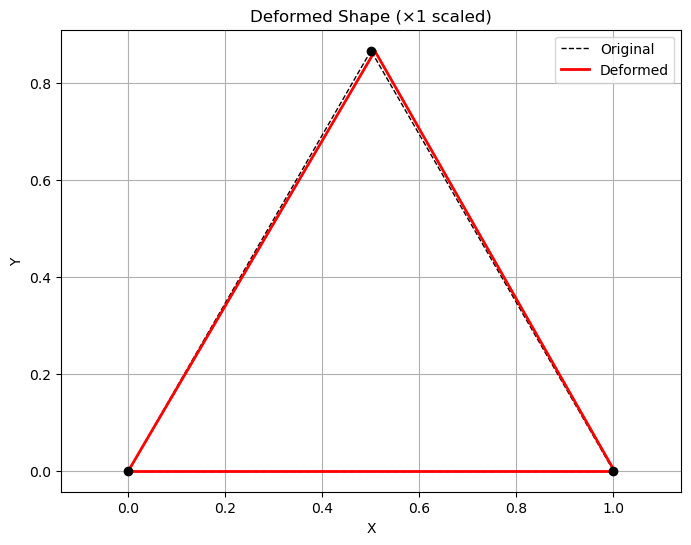

In [2]:
# 5번 문제 코드 실행 결과
FEM_Calculator()

node number:4
element number:4
Node 1 coordinate and force (format: x, y, fx, fy):0,0,0,0
Node 2 coordinate and force (format: x, y, fx, fy):1,0,1000000000,0
Node 3 coordinate and force (format: x, y, fx, fy):1,1,0,-1000000000
Node 4 coordinate and force (format: x, y, fx, fy):0,1,0,0
Element 1 node number (format: 1,2):1,2
Element 1 elastic modulus (E: GPa):1
Element 1 area (A: m^2):1
Element 2 node number (format: 1,2):2,3
Element 2 elastic modulus (E: GPa):1
Element 2 area (A: m^2):1
Element 3 node number (format: 1,2):1,3
Element 3 elastic modulus (E: GPa):1
Element 3 area (A: m^2):1
Element 4 node number (format: 1,2):3,4
Element 4 elastic modulus (E: GPa):1
Element 4 area (A: m^2):1
BC: (DOF, format(fixed coordinate): xy, x, y, enter)
Node 1 bondary condition (format: xy, x, y, enter): xy
Node 2 bondary condition (format: xy, x, y, enter): y
Node 3 bondary condition (format: xy, x, y, enter): 
Node 4 bondary condition (format: xy, x, y, enter): xy
[K]
[[ 1.354e+09  3.536e+08 -1.0

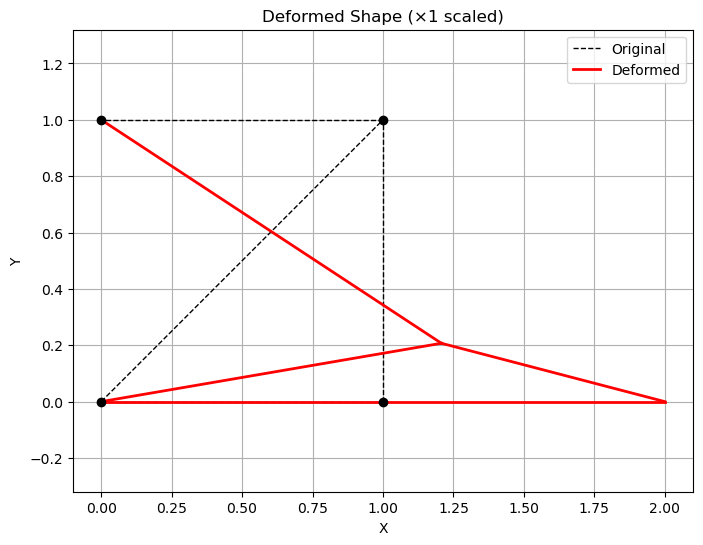

In [4]:
# 4번 결과 검증 --> 1GN, E=1GPa, A=1m^2 설정시 u2, u3 결과 일치
FEM_Calculator()